# Haridas_Indrajit_Assignment2

**GitHub:** *https://github.com/Indrajitharidas/PythonClass*

## Table of Contents:
1) Preamble

2) Viz 1: *Correlation between stock attributes of Google and MMM*

3) Viz 2: *Time series decomposition to identify seasonality, trend and residuals*

4) Viz 3: *Plot and see if close price and volumes are correlated for the given stocks*

5) Viz 4: *ARIMA Visualization for Close price and Volume of Google Stock*

6) Viz 5: *Stationarity identification by visualizing first difference*

7) Viz 6: *Regression plot between Google Close Price and MMM Volume and vice versa*

8) Viz 7: *Intraday distribution and correlation between gain in Google stock price and previous day gain of MMM stock price*

9) Viz 8: *Boxplot for the intraday gain for Google and MMM stock price*

10) Viz 9: *Relation between *RSI* of MMM and *Closing Price* of Google and vice versa*

11) Viz 10: *Let's see if moving averages of MMM can help us trade in Google stock!
*

## Preamble

In [189]:
# Load packages
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [190]:
# Load data set
google = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
mmm = pd.read_csv('MMM_2006-01-01_to_2018-01-01.csv')

In [191]:
df = pd.merge(google, mmm, how = 'inner', on = 'Date')
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.DatetimeIndex(df['Date'])
df.head()

,Date,Open_x,High_x,Low_x,Close_x,Volume_x,Name_x,Open_y,High_y,Low_y,Close_y,Volume_y,Name_y
Date,,,,,,,,,,,,,
2006-01-03,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,77.76,79.35,77.24,79.11,3117200,MMM
2006-01-04,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,79.49,79.49,78.25,78.71,2558000,MMM
2006-01-05,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,78.41,78.65,77.56,77.99,2529500,MMM
2006-01-06,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,78.64,78.90,77.64,78.63,2479500,MMM
2006-01-09,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,78.50,79.83,78.46,79.02,1845600,MMM


## Viz 1

Let's see how the price and volume variations are related for Google and 3M stocks!

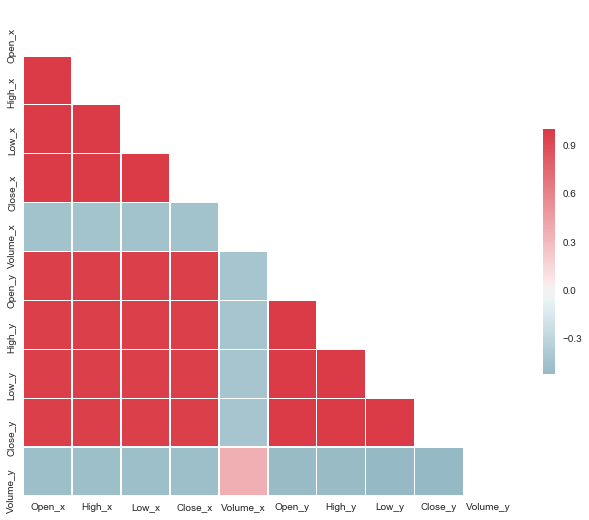

In [192]:
# Since our aim is to find if we can do a pair trading between Google and MMM, let's see their covariance.

d = df[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Open_y', 'High_y', 'Low_y', 'Close_y', 'Volume_y']]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Viz 2

Let's decompose both the stocks and identify if there is a match in seasonality, trend and residuals.

*After plotting for the whole dataset, we filterred data and considered datapoints only after 2016-01-01 in order to read seasonality more closely*

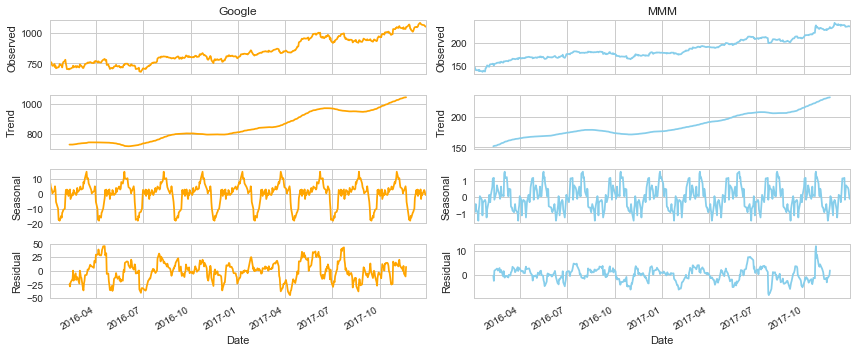

In [193]:
def plotseasonal(res, axes, col ):
    res.observed.plot(ax=axes[0], legend=False, color = col)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, color = col)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False, color = col)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, color = col)
    axes[3].set_ylabel('Residual')


y1 = df[df['Date'] > '2016-01-01']['Close_x']
y2 = df[df['Date'] > '2016-01-01']['Close_y']

decomposition1 = sm.tsa.seasonal_decompose(y1, model='additive', freq=52)
decomposition2 = sm.tsa.seasonal_decompose(y2, model='additive', freq=52)


fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(decomposition1, axes[:,0], 'orange')
plotseasonal(decomposition2, axes[:,1], 'skyblue')

axes[0, 0].set_title('Google')
axes[0, 1].set_title('MMM')

plt.tight_layout()
plt.show()

## Viz 3

Let's see if the volumes are autocorrelated. Since they are the fuel for the momentum, our hypothesis is that there must be autocoreelation. Let's see!

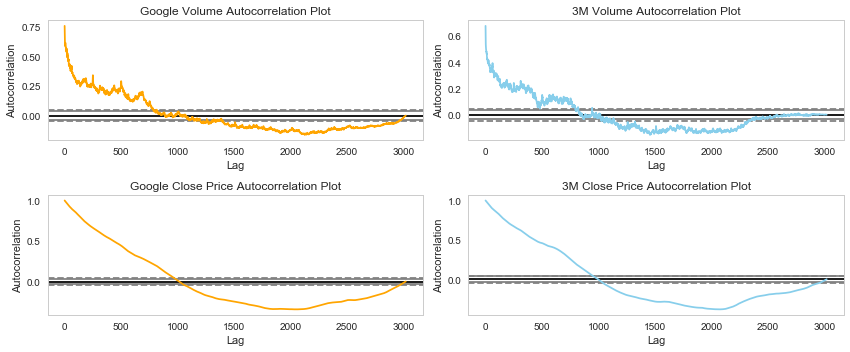

In [194]:
from pandas.tools.plotting import autocorrelation_plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,5))

autocorrelation_plot(df['Volume_x'], ax = axes[0, 0], color = 'orange')
axes[0, 0].set_title('Google Volume Autocorrelation Plot')

autocorrelation_plot(df['Volume_y'], ax = axes[0, 1], color = 'skyblue')
axes[0, 1].set_title('3M Volume Autocorrelation Plot')

autocorrelation_plot(df['Close_x'], ax = axes[1, 0], color = 'orange')
axes[1, 0].set_title('Google Close Price Autocorrelation Plot')

autocorrelation_plot(df['Close_y'], ax = axes[1, 1], color = 'skyblue')
axes[1, 1].set_title('3M Close Price Autocorrelation Plot')

plt.tight_layout()

## Viz 4

#### Fitting Seasonal ARIMA Models for Google Prices

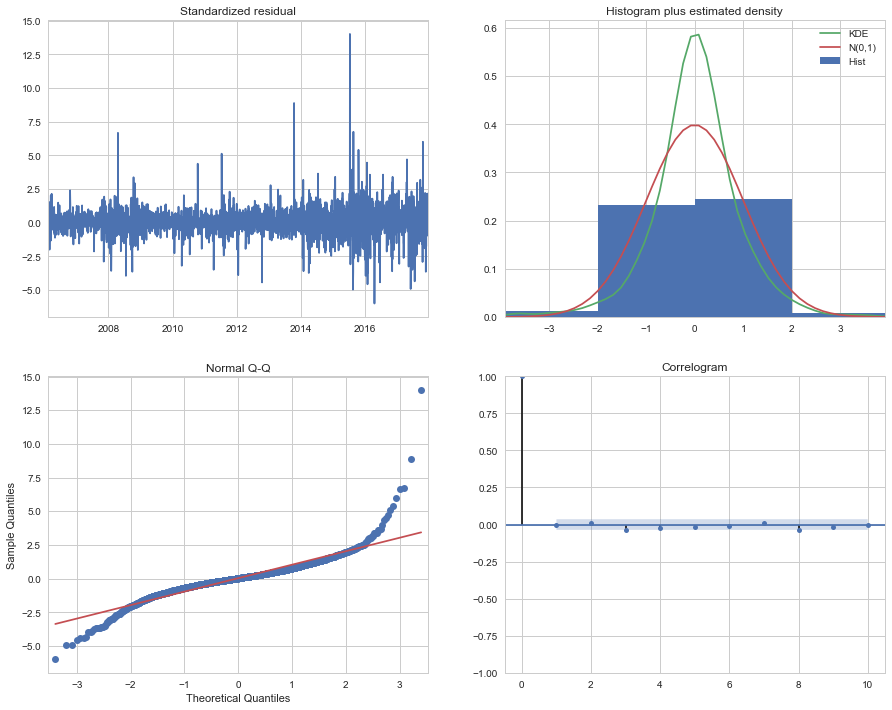

In [195]:
## Below given parameters were calculates using a different python script
mod = sm.tsa.statespace.SARIMAX(df['Close_x'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()


results.plot_diagnostics(figsize=(15, 12))
plt.show()


#### Fitting ARIMA Models for Google Stock Trading Volume

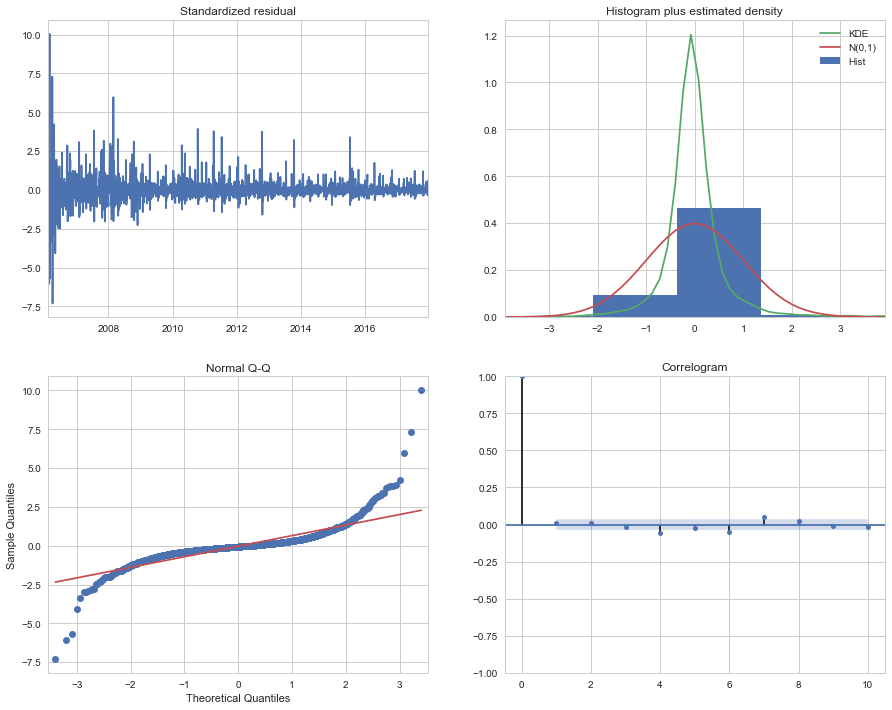

In [196]:
## Below given parameters were calculates using a different python script
mod = sm.tsa.statespace.SARIMAX(df['Volume_x'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()


results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Viz 5

Let's see if first difference makes the Close Price (time series) stationary. Evaluating Visually, although correct method would be to to the kpss test.

In [197]:
# Given time series is not stationary, so we will take first difference of the closing price that will make it stationary
y1 = np.diff(df['Close_x'])
y2 = np.diff(df['Close_y'])


In [198]:
df["Date"] = pd.to_datetime(df["Date"])

output_notebook()
out = figure(x_axis_type="datetime", plot_width=800, plot_height=250)

out.line(pd.to_datetime(df['Date'][1:]), y1, line_width=2, color='orange', alpha=0.8, legend='Google')
out.line(pd.to_datetime(df['Date'][1:]), y2, line_width=2, color='skyblue', alpha=0.8, legend='MMM')

show(out)

Loading BokehJS ...

Yes, first difference of both MMM and Google's close price seem to be a stationary time series.

## Viz 6

Regression plot between the closing price of Google and Volume of MMM (and vice versa), in order to identify if pair trading can be done.

Below is the graph between Closing Price of Google and Volume of MMM


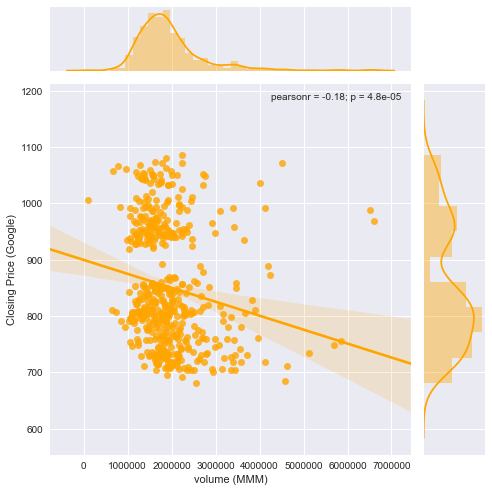

In [199]:
print('Below is the graph between Closing Price of Google and Volume of MMM')

sns.set(style="darkgrid", color_codes=True)
g1 = sns.jointplot("Volume_y", "Close_x", data=df[df['Date'] > '2016-01-01'], kind="reg", color="orange", size=7)
g1.set_axis_labels( 'volume (MMM)', 'Closing Price (Google)')

plt.tight_layout()

Below is the graph between Closing Price of MMM and Volume of Google


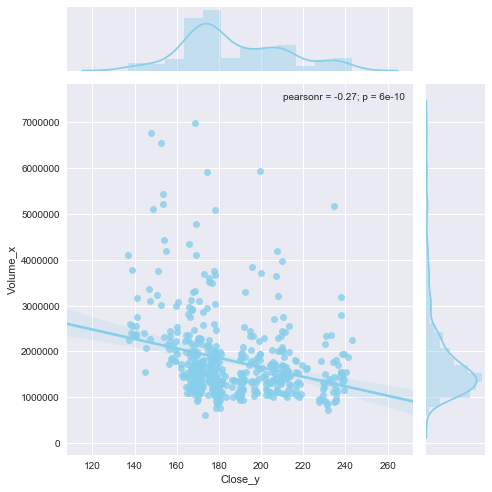

In [200]:
print('Below is the graph between Closing Price of MMM and Volume of Google')

g2 = sns.jointplot("Close_y", "Volume_x", data=df[df['Date'] > '2016-01-01'], kind="reg", color="skyblue", size=7)
g1.set_axis_labels('Closing Price (MMM)', 'volume (Google)')

plt.tight_layout()

## Viz 7

How today's intraday change in price varies with intraday movement of MMM for the previous day.

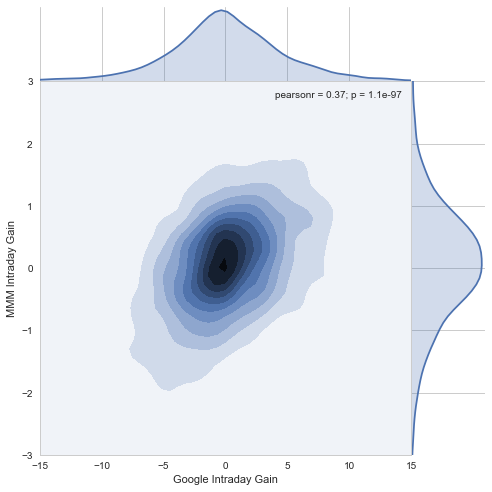

In [206]:
x1 = df['Close_x'] - df['Open_x']
x2 = df['Close_y'] - df['Open_y']

sns.set(style="whitegrid")
g = sns.jointplot(x1[1:], x2[0:len(x2)-1], kind="kde", size=7, space=0, xlim = (-15, 15), ylim = (-3, 3))
g.set_axis_labels('Google Intraday Gain', 'MMM Intraday Gain')

## Viz 8

Boxplot for the intraday gain for Google and MMM stock price

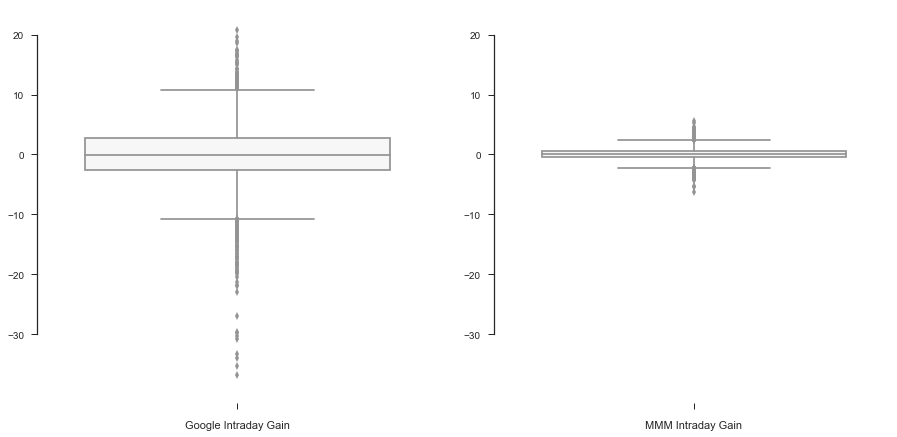

In [205]:
sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,7), sharey = True)

sns.boxplot(y=x1[1:], palette="PRGn", ax = ax1)
sns.boxplot(y=x2[0:len(x2)-1], palette="PRGn", ax = ax2)

ax1.set_xlabel('Google Intraday Gain')
ax2.set_xlabel('MMM Intraday Gain')

sns.despine(offset=10, trim=True)

## Viz 9

Relation between *RSI* of MMM and *Closing Price* of Google and vice versa

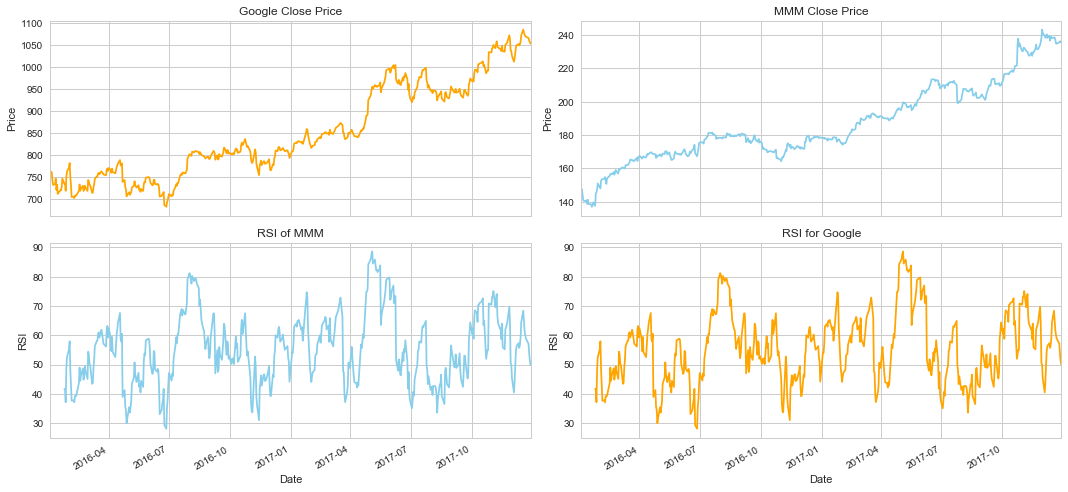

In [203]:
sns.set_style('whitegrid')

def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + rs)

d = df[df['Date'] > '2016-01-01']
d['Date'] = pd.to_datetime(d['Date'])

d['RSI_x'] = RSI(d['Close_x'], 14)
d['RSI_y'] = RSI(d['Close_x'], 14)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,7), sharex = True)

d.plot(y=['Close_x'], ax = axes[0, 0], color = 'orange', legend = False)
axes[0, 0].set_title('Google Close Price')
axes[0, 0].set_ylabel('Price')

d.plot(y=['RSI_y'], ax = axes[1, 0], color = 'skyblue', legend = False)
axes[1, 0].set_title('RSI of MMM')
axes[1, 0].set_ylabel('RSI')

d.plot(y=['Close_y'], ax = axes[0, 1], color = 'skyblue', legend = False)
axes[0, 1].set_title('MMM Close Price')
axes[0, 1].set_ylabel('Price')

d.plot(y=['RSI_x'], ax = axes[1, 1], color = 'orange', legend = False)
axes[1, 1].set_title('RSI for Google')
axes[1, 1].set_ylabel('RSI')


plt.tight_layout()

## Viz 10

Let's see if moving averages of MMM can help us trade in Google stock!

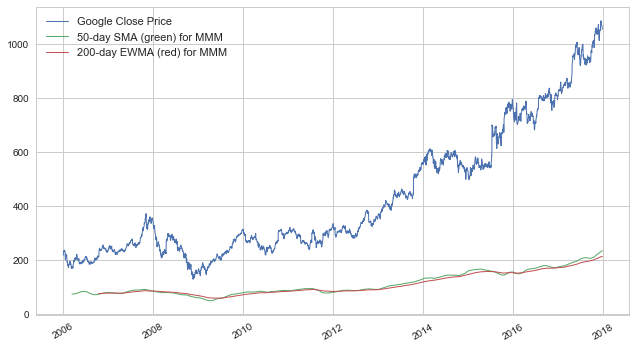

In [204]:
# Simple Moving Average 
def SMA(data, ndays): 
 SMA = pd.Series(pd.rolling_mean(data['Close_y'], ndays), name = 'SMA') 
 data = data.join(SMA) 
 return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
 EMA = pd.Series(pd.ewma(data['Close_y'], span = ndays, min_periods = ndays - 1), 
 name = 'EWMA_' + str(ndays)) 
 data = data.join(EMA) 
 return data

close = df['Close_x']

# Compute the 50-day SMA for MMM
n = 50
SMA_3m = SMA(df,n)
SMA_3m = SMA_3m.dropna()
SMA = SMA_3m['SMA']

# Compute the 200-day EWMA for MMM
ew = 200
EWMA_3m = EWMA(df,ew)
EWMA_3m = EWMA_3m.dropna()
EWMA = EWMA_3m['EWMA_200']

# Plotting the NIFTY Price Series chart and Moving Averages below
plt.figure(figsize=(9,5))
plt.plot(df['Close_x'],lw=1, label='Google Close Price')
plt.plot(SMA,'g',lw=1, label='50-day SMA (green) for MMM')
plt.plot(EWMA,'r', lw=1, label='200-day EWMA (red) for MMM')
plt.legend(loc=2,prop={'size':11})
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.tight_layout()